In [1]:
%pylab inline
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (12,4)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pathlib

In [3]:
import numpy as np
import pandas as pd

In [5]:
DATA_DIR = pathlib.Path("../data")

# Loading data

In [6]:
df = pd.read_csv(DATA_DIR / "AEP_hourly.csv", parse_dates=["Datetime"], index_col="Datetime")

In [7]:
df

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0
...,...
2018-01-01 20:00:00,21089.0
2018-01-01 21:00:00,20999.0
2018-01-01 22:00:00,20820.0


## Fix timestamps

In [8]:
df.index.is_monotonic, df.index.is_unique

(False, False)

In [9]:
df = df.sort_index()
df

,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0
...,...
2018-08-02 20:00:00,17673.0
2018-08-02 21:00:00,17303.0
2018-08-02 22:00:00,17001.0


### New index

In [10]:
new_idx = pd.date_range("2004-10-01 01:00:00", "2018-08-03 00:00:00", freq="1H")

In [11]:
df[~df.index.duplicated(keep='first')]

,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0
...,...
2018-08-02 20:00:00,17673.0
2018-08-02 21:00:00,17303.0
2018-08-02 22:00:00,17001.0


In [12]:
dfi = df[~df.index.duplicated(keep='first')].reindex(new_idx)

In [13]:
dfi.index.is_monotonic, dfi.index.is_unique, dfi.index.freq

(True, True, <Hour>)

### Missing values

In [14]:
dfi.isnull().mean()

AEP_MW    0.000223
dtype: float64

In [15]:
dfi.ffill(inplace=True)

# DalaModule

In [17]:
# PyTorch imports
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset

# PyTorch Lightning imports
import pytorch_lightning as pl

In [19]:
class ElectricityDataset(Dataset):
    """Dataset which samples the data from hourly electricity data."""

    def __init__(self, df, samples, hist_len=168, fct_len=24, col="AEP_MW"):
        self.hist_num = hist_len
        self.fct_num = fct_len
        self.hist_len = pd.Timedelta(hours=hist_len)
        self.fct_len = pd.Timedelta(hours=fct_len)
        self.offset = pd.Timedelta(hours=1)

        self.max_ts = df.index.max() - self.hist_len - self.fct_len + self.offset
        self.raw_data = df

        assert samples <= self.raw_data[:self.max_ts].shape[0]
        self.samples = samples
        self.col = col
        self.sample()

    def sample(self):
        """Sample individual series as needed."""
        
        self.sample_idx = (self
                           .raw_data[:self.max_ts]
                           .index
                           .to_series()
                           .sample(self.samples, replace=False)
                           .index)

    def __len__(self):
        return self.samples

    def __getitem__(self, idx):
        start_ts = self.sample_idx[idx]

        hs, he = start_ts, start_ts + self.hist_len - self.offset
        fs, fe = he + self.offset, he + self.fct_len

        hist_data = self.raw_data[hs:].iloc[:self.hist_num]
        fct_data = self.raw_data[fs:].iloc[:self.fct_num]

        return (torch.Tensor(hist_data[self.col].values),
                torch.Tensor(fct_data[self.col].values))

In [20]:
ds = ElectricityDataset(dfi, 10)

In [21]:
start_ts = ds.sample_idx[4]

In [22]:
dfi[start_ts:].head()

,AEP_MW
2017-10-25 21:00:00,14844.0
2017-10-25 22:00:00,14432.0
2017-10-25 23:00:00,13679.0
2017-10-26 00:00:00,12913.0
2017-10-26 01:00:00,12444.0


In [23]:
dfi[start_ts+pd.Timedelta(days=7):].head()

,AEP_MW
2017-11-01 21:00:00,15072.0
2017-11-01 22:00:00,14654.0
2017-11-01 23:00:00,13811.0
2017-11-02 00:00:00,12855.0
2017-11-02 01:00:00,12224.0


In [24]:
ds[4]

(tensor([14844., 14432., 13679., 12913., 12444., 12210., 12084., 12210., 12539.,
         13383., 14802., 15666., 15527., 15368., 14918., 14535., 14203., 14074.,
         13793., 13543., 13508., 13495., 13802., 14500., 14463., 14140., 13547.,
         12881., 12388., 12223., 12091., 12017., 12333., 13074., 14335., 15222.,
         15056., 14785., 14560., 14196., 13902., 13756., 13626., 13622., 13450.,
         13429., 13588., 13779., 13426., 13095., 12664., 12001., 11478., 11139.,
         10997., 11022., 11030., 11397., 11859., 12523., 13004., 13351., 13677.,
         13741., 13610., 13505., 13368., 13296., 13319., 13472., 13704., 13945.,
         13700., 13336., 12898., 12369., 11940., 11581., 11479., 11455., 11536.,
         11636., 12088., 12480., 13029., 13481., 13554., 13676., 13741., 13632.,
         13539., 13660., 13778., 14042., 14445., 14960., 14848., 14375., 13926.,
         13427., 13092., 12953., 12920., 12963., 13328., 14102., 15629., 16476.,
         16518., 16295., 162

In [25]:
class ElectricityDataModule(pl.LightningDataModule):
    """DataModule for electricity data."""

    def __init__(self, df,
                 train_range=("2004", "2015"),
                 val_range=("2016","2017"),
                 test_range=("2018", None),
                 factor=0.5,
                 batch_size=64,
                 workers=3):

        super().__init__()
        self.raw_data = df
        self.train_range = train_range
        self.val_range = val_range
        self.test_range = test_range
        self.factor = factor
        self.batch_size = batch_size
        self.workers = workers

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            train_df = self.raw_data[slice(*self.train_range)]
            val_df = self.raw_data[slice(*self.val_range)]

            self.train_ds = ElectricityDataset(train_df,
                                               samples=int(self.factor * train_df.shape[0]))
            self.val_ds = ElectricityDataset(val_df,
                                             samples=int(self.factor * val_df.shape[0]))

        if stage == "test" or stage is None:
            test_df = self.raw_data[slice(*self.test_range)]
            self.test_ds = ElectricityDataset(test_df,
                                              samples=int(self.factor * test_df.shape[0]))

    
    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, num_workers=self.workers)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, num_workers=self.workers)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, num_workers=self.workers)

# Encoder network

In [26]:
class ElectricityEncoder(pl.LightningModule):
    """Encoder network for encoder-decoder forecast model."""
   
    def __init__(self, hist_len=168, fct_len=24, num_layers=1, hidden_units=8):
        super().__init__()
        self.hist_len = hist_len
        self.fct_len = fct_len
        self.num_layers = num_layers
        self.hidden_units = hidden_units

        self.encoder = nn.LSTM(input_size=1,
                               hidden_size=self.hidden_units,
                               num_layers=self.num_layers,
                               batch_first=True)

    def forward(self, x):
        output, (henc, cenc) = self.encoder(x.view(x.shape[0], x.shape[1], 1))
        
        
        return output, henc, cenc

In [27]:
encoder = ElectricityEncoder()

In [28]:
hist_sample = torch.cat([ds[3][0].unsqueeze(0),
                         ds[5][0].unsqueeze(0)])

fct_sample = torch.cat([ds[3][1].unsqueeze(0),
                        ds[5][1].unsqueeze(0)])

output, hc, cc = encoder(hist_sample)

In [29]:
hist_sample.shape

torch.Size([2, 168])

In [30]:
hc.shape

torch.Size([1, 2, 8])

In [31]:
output.shape

torch.Size([2, 168, 8])

In [32]:
cc.shape

torch.Size([1, 2, 8])

# Decoder network

In [33]:
class ElectricityDecoder(pl.LightningModule):
    """Encoder network for encoder-decoder forecast model."""
   
    def __init__(self, hist_len=168, fct_len=24, num_layers=1, hidden_units=8):
        super().__init__()
        self.hist_len = hist_len
        self.fct_len = fct_len
        self.num_layers = num_layers
        self.hidden_units = hidden_units

        self.decoder = nn.LSTM(input_size=1,
                               hidden_size=self.hidden_units,
                               num_layers=self.num_layers,
                               batch_first=True)
        self.linear = nn.Linear(self.hidden_units, 1)

    def forward(self, x, hidden):
        output, (hc, cc) = self.decoder(x.view(x.shape[0], x.shape[1], 1), hidden)
        output = self.linear(output.squeeze(1))
        return output, hc, cc

In [34]:
decoder = ElectricityDecoder()

In [35]:
a, b, c = decoder(hist_sample[:, [-1]], (hc, cc))

In [36]:
decoder(a, (b, c))

(tensor([[-0.1996],
         [-0.1996]], grad_fn=<AddmmBackward>),
 tensor([[[ 0.0671, -0.1455, -0.1314, -0.0558, -0.3358, -0.3724,  0.1521,
           -0.1801],
          [ 0.0671, -0.1455, -0.1314, -0.0558, -0.3358, -0.3724,  0.1521,
           -0.1801]]], grad_fn=<StackBackward>),
 tensor([[[  0.1126,  -0.2618,  -0.2442,  -0.1641,  -0.6577, -84.0380,   0.2844,
            -0.4555],
          [  0.1126,  -0.2618,  -0.2442,  -0.1641,  -0.6577, -84.0380,   0.2844,
            -0.4555]]], grad_fn=<StackBackward>))

In [37]:
a.shape

torch.Size([2, 1])

# Encoder-decoder model

In [38]:
class ElectricityModel(pl.LightningModule):
    """Encoder network for encoder-decoder forecast model."""
   
    def __init__(self, hist_len=168, fct_len=24, num_layers=1, hidden_units=8, lr=1e-3):
        super().__init__()
        self.hist_len = hist_len
        self.fct_len = fct_len
        self.num_layers = num_layers
        self.hidden_units = hidden_units
        self.lr = lr

        self.encoder = ElectricityEncoder(hist_len, fct_len, num_layers, hidden_units)
        
        self.MLPglob = nn.Linear(encoded, self.output+1)

        self.MLPlocs = nn.ModuleList([nn.Linear(2, 3) for i in range(self.output)]).to(self.device)

        
        self.decoder = ElectricityDecoder(hist_len, fct_len, num_layers, hidden_units)

    def forward(self, x):
        forecasts = []
        enc, hh, cc = self.encoder(x)
        enc = x[:, [-1]]

        for i in range(self.fct_len):
            enc, hc, cc = self.decoder(enc, (hh, cc))
            forecasts.append(enc)
        forecasts = torch.cat(forecasts, dim=1)
        return forecasts

    def training_step(self, batch, batch_idx):
        x, y = batch
        fct = self(x)
        return F.mse_loss(fct, y)

    def validation_step(self, batch, batch_idx):

        x, y = batch
        logits = self(x)
        loss = F.mse_loss(logits, y)
        self.log('val_mse', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

# Scaling

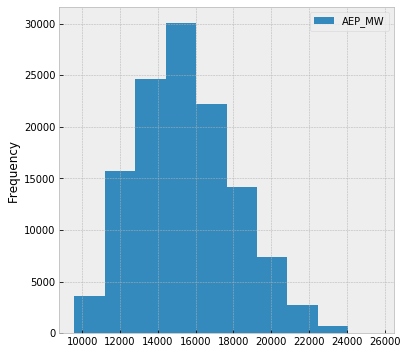

In [39]:
plt.figure(figsize=(6,6))
dfi.plot(kind="hist", ax=plt.gca())

In [40]:
LIMH, LIML =26e3, 9e3

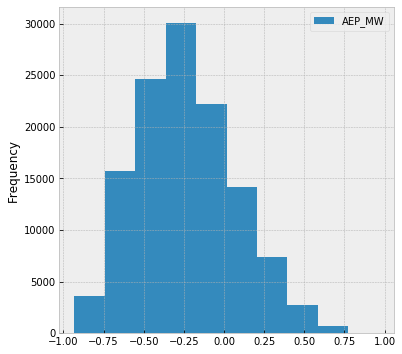

In [41]:
plt.figure(figsize=(6,6))
((2 * dfi - LIML - LIMH) / (LIMH - LIML)).plot(kind="hist", ax=plt.gca())

In [74]:
dfi

,AEP_MW
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0
...,...
2018-08-02 20:00:00,17673.0
2018-08-02 21:00:00,17303.0
2018-08-02 22:00:00,17001.0
2018-08-02 23:00:00,15964.0


In [48]:
dfs = (2 * dfi - LIML - LIMH) / (LIMH - LIML)

ds = ElectricityDataModule(dfs, batch_size=32)
model = ElectricityModel(lr=1e-3, hidden_units=64)
trainer = pl.Trainer(max_epochs=5, progress_bar_refresh_rate=1, gpus=1)
trainer.fit(model, ds)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name    | Type               | Params
-----------------------------------------------
0 | encoder | ElectricityEncoder | 17.2 K
1 | decoder | ElectricityDecoder | 17.2 K
-----------------------------------------------
34.4 K    Trainable params
0         Non-trainable params
34.4 K    Total params
0.137     Total estimated model params size (MB)


1

In [49]:
hist_sample_scaled = (2 * hist_sample - LIML - LIMH) / (LIMH - LIML)

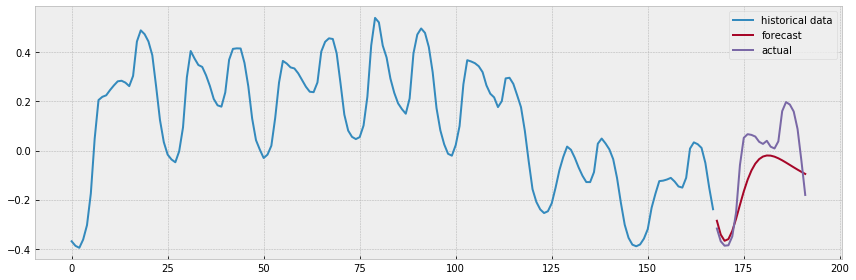

In [50]:
plt.plot((( 2 * hist_sample.numpy() - LIML - LIMH) / (LIMH - LIML))[0], label="historical data")
plt.plot(np.arange(168, 192, 1), model(hist_sample_scaled).detach().numpy()[0], label="forecast")
plt.plot(np.arange(168, 192, 1), (( 2 * fct_sample.numpy() - LIML - LIMH) / (LIMH - LIML))[0], label="actual")

plt.legend(loc=0)
plt.tight_layout()

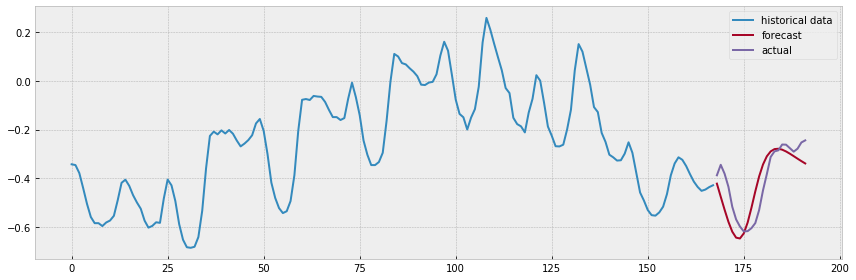

In [51]:
plt.plot((( 2 * hist_sample.numpy() - LIML - LIMH) / (LIMH - LIML))[1], label="historical data")
plt.plot(np.arange(168, 192, 1), model(hist_sample_scaled).detach().numpy()[1], label="forecast")
plt.plot(np.arange(168, 192, 1), (( 2 * fct_sample.numpy() - LIML - LIMH) / (LIMH - LIML))[1], label="actual")

plt.legend(loc=0)
plt.tight_layout()

In [65]:
ds.setup()
dl = ds.test_dataloader()

In [66]:
ds.test_dataloader()

In [71]:
ds.get_init_arguments_and_types

<bound method LightningDataModule.get_init_arguments_and_types of <class '__main__.ElectricityDataModule'>>